## Подготовка данных

In [145]:
#%%capture
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import Pipeline
from sklearn.metrics import make_scorer

from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor

!pip install -U seaborn
sns.set(rc={'figure.figsize':(15, 10)})

import warnings
warnings.filterwarnings('ignore')

Defaulting to user installation because normal site-packages is not writeable
Requirement already up-to-date: seaborn in /home/jovyan/.local/lib/python3.7/site-packages (0.11.2)


Загрузим данные и посмотрим их описание

In [146]:
raw_df = pd.read_csv('/datasets/autos.csv')
df = raw_df.copy(deep=True)

In [147]:
df.isna().mean().apply('{:.2%}'.format)

DateCrawled           0.00%
Price                 0.00%
VehicleType          10.58%
RegistrationYear      0.00%
Gearbox               5.60%
Power                 0.00%
Model                 5.56%
Kilometer             0.00%
RegistrationMonth     0.00%
FuelType              9.28%
Brand                 0.00%
NotRepaired          20.08%
DateCreated           0.00%
NumberOfPictures      0.00%
PostalCode            0.00%
LastSeen              0.00%
dtype: object

Видим пропуски в 5 колонках

In [148]:
df.describe()

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode
count,354369.000000,354369.000000,354369.000000,354369.000000,354369.000000,354369.0,354369.000000
mean,4416.656776,2004.234448,110.094337,128211.172535,5.714645,0.0,50508.689087
std,4514.158514,90.227958,189.850405,37905.341530,3.726421,0.0,25783.096248
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49413.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71083.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


In [149]:
df.sample(5)

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
286707,2016-03-20 18:54:48,1000,sedan,1989,manual,129,5er,150000,4,petrol,bmw,no,2016-03-20 00:00:00,0,35708,2016-04-06 00:46:24
61905,2016-03-11 22:40:34,480,small,1996,manual,45,polo,150000,0,petrol,volkswagen,NaN,2016-03-11 00:00:00,0,51375,2016-03-14 21:18:16
4010,2016-03-17 10:56:05,1700,small,2004,manual,60,ka,90000,1,petrol,ford,no,2016-03-17 00:00:00,0,66299,2016-03-19 10:16:04
222478,2016-03-11 18:52:18,500,sedan,1995,manual,0,astra,90000,5,petrol,opel,yes,2016-03-11 00:00:00,0,79774,2016-03-18 04:15:55
15422,2016-03-24 21:47:08,2450,sedan,1996,auto,299,a8,150000,6,petrol,audi,no,2016-03-24 00:00:00,0,89278,2016-04-05 15:17:43


Приведем имена колонок к одному регистру

In [150]:
df.columns = map(str.lower, df.columns)
df.columns

Index(['datecrawled', 'price', 'vehicletype', 'registrationyear', 'gearbox',
       'power', 'model', 'kilometer', 'registrationmonth', 'fueltype', 'brand',
       'notrepaired', 'datecreated', 'numberofpictures', 'postalcode',
       'lastseen'],
      dtype='object')

Поменяем тип данных в некоторых колонках на datetime

In [151]:
to_dt = ['datecrawled', 'datecreated', 'lastseen']

In [152]:
for col in to_dt:
    df[col] = pd.to_datetime(df[col])

Посмотрим, сколько объявлений были созданы до 2016 года

In [153]:
len(df[df['datecreated'].dt.year < 2016])

26

Уберем такие объявления

In [154]:
df = df.query('datecreated.dt.year == 2016')

Заменим месяц регистрации равный 0 на 1

In [155]:
df['registrationmonth'] = df['registrationmonth'].replace(0, 1)

Посмотрим на распределение стоимости автомобилей

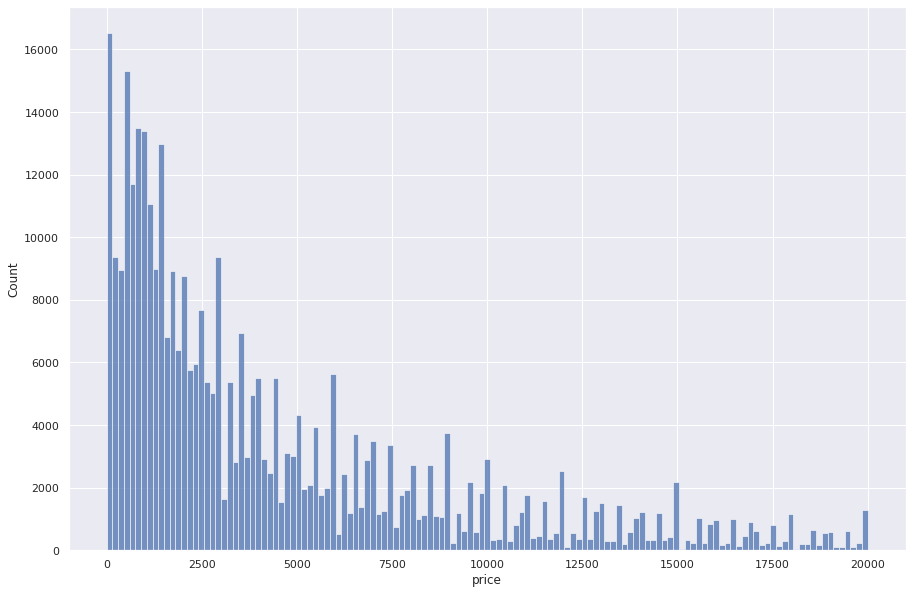

In [156]:
sns.histplot(data=df['price'])

In [157]:
len(df[df['price'] == 0])

10772

Значения медианы и среднего очень сильно отличаются. Избавимся от автомобилей с ценой 0

In [158]:
df = df.query('price > 0')

Посмотрим на распределение мощности в л.с. у автомобилей

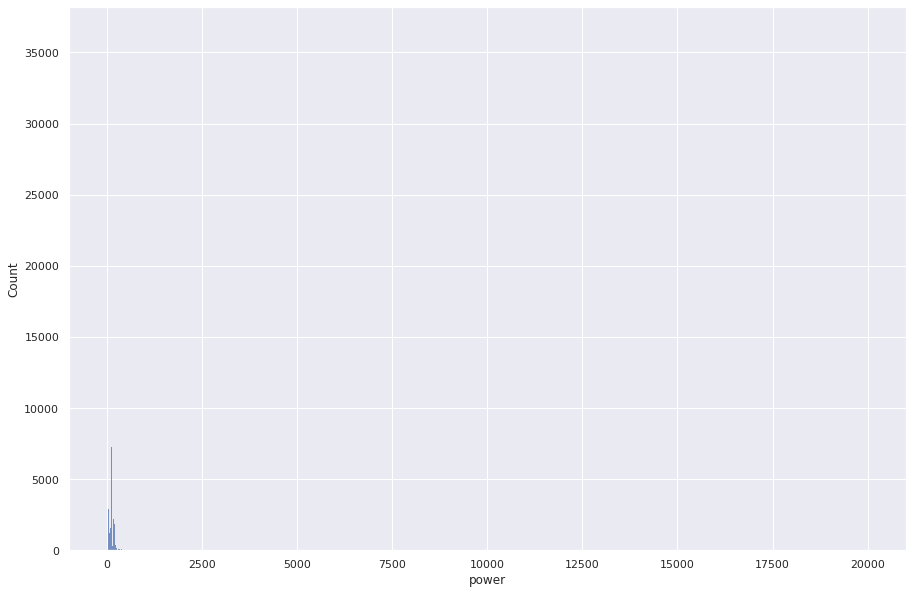

In [159]:
sns.histplot(data=df['power'])

Выберем автомобили, мощность которых не превышает 1500 л.с.

In [160]:
df = df.query('power < 1500')

Заменим пропущенные значения в колонке мощность на медиану

In [161]:
df['power'] = df['power'].fillna(df['power'].median())

Заменим пропуски в колонке vehicletype на other

In [162]:
df['vehicletype'] = df['vehicletype'].fillna('other')

Посмотрим на колонку gearbox

In [163]:
df['gearbox'].value_counts()

manual    261224
auto       64812
Name: gearbox, dtype: int64

Заменим пропуски в колонке gearbox на other

In [164]:
df['gearbox'] = df['gearbox'].fillna('other')

Посмотрим на колонку fueltype

In [165]:
df['fueltype'].value_counts()

petrol      210636
gasoline     97120
lpg           5163
cng            552
hybrid         227
other          169
electric        88
Name: fueltype, dtype: int64

Переименуем схожие категории в одну и уберем пропуски

In [166]:
df['fueltype'] = df['fueltype'].replace('petrol', 'gasoline')
df['fueltype'] = df['fueltype'].replace('lpg', 'gas')
df['fueltype'] = df['fueltype'].replace('cng', 'gas')
df['fueltype'] = df['fueltype'].fillna('other')

In [167]:
df['fueltype'].value_counts()

gasoline    307756
other        29591
gas           5715
hybrid         227
electric        88
Name: fueltype, dtype: int64

Посмотрим на колонку notrepaired

In [168]:
df['notrepaired'].value_counts()

no     243569
yes     34018
Name: notrepaired, dtype: int64

Заменим пропуски на категорию other, поскольку мы не можем знать точно, была машина в ремонте или нет

In [169]:
df['notrepaired'] = df['notrepaired'].fillna('other')

Посмотрим на колонку model

In [170]:
df['model'].value_counts()

golf                  28234
other                 23698
3er                   19170
polo                  12617
corsa                 12188
                      ...  
i3                        8
rangerover                4
serie_3                   3
range_rover_evoque        2
serie_1                   1
Name: model, Length: 250, dtype: int64

In [171]:
df['model'].unique()

array(['golf', nan, 'grand', 'fabia', '3er', '2_reihe', 'c_max',
       '3_reihe', 'passat', 'navara', 'ka', 'polo', 'twingo', 'a_klasse',
       'scirocco', '5er', 'meriva', 'arosa', 'other', 'c4', 'civic',
       'transporter', 'punto', 'e_klasse', 'clio', 'kadett', 'kangoo',
       'one', 'fortwo', '1er', 'b_klasse', 'signum', 'astra', 'a8',
       'jetta', 'fiesta', 'c_klasse', 'micra', 'vito', 'sprinter', '156',
       'escort', 'forester', 'xc_reihe', 'scenic', 'a4', 'a1', 'insignia',
       'combo', 'focus', 'tt', 'corsa', 'a6', 'jazz', 'omega', 'slk',
       '7er', '80', '147', '100', 'z_reihe', 'sportage', 'sorento', 'v40',
       'ibiza', 'mustang', 'eos', 'touran', 'getz', 'a3', 'almera',
       'megane', 'lupo', 'r19', 'zafira', 'caddy', 'mondeo', 'cordoba',
       'colt', 'impreza', 'vectra', 'berlingo', 'tiguan', 'i_reihe',
       'espace', 'sharan', '6_reihe', 'panda', 'up', 'seicento', 'ceed',
       '5_reihe', 'yeti', 'octavia', 'mii', 'rx_reihe', '6er', 'modus',
     

250 уникальных значений. Заменим пропуски на other

In [172]:
df['model'] = df['model'].fillna('other')

Посмотрим сколько данных мы потеряли

In [173]:
print(f'Доля потерянных данных: {(1 - (df.shape[0] / raw_df.shape[0])):.2%}')

Доля потерянных данных: 3.10%


In [174]:
df.columns

Index(['datecrawled', 'price', 'vehicletype', 'registrationyear', 'gearbox',
       'power', 'model', 'kilometer', 'registrationmonth', 'fueltype', 'brand',
       'notrepaired', 'datecreated', 'numberofpictures', 'postalcode',
       'lastseen'],
      dtype='object')

Удалим колонки с месяцами и годами, которые не несут важной для нас информации, кроме registrationyear

In [175]:
df = df.drop(['datecrawled', 'datecreated', 'lastseen'], axis=1)

Перед обучением моделей нам необходимо преобразовать категориальные признаки с помощью LabelEncoding

In [176]:
encoder = OrdinalEncoder()

In [177]:
X_cat.columns

Index(['vehicletype', 'gearbox', 'model', 'fueltype', 'brand', 'notrepaired'], dtype='object')

In [178]:
raw_X.tail()

,vehicletype,registrationyear,gearbox,power,model,kilometer,registrationmonth,fueltype,brand,notrepaired,numberofpictures,postalcode
354363,bus,2000,manual,0,zafira,150000,3,gasoline,opel,no,0,26624
354365,other,2005,other,0,other,20000,1,other,sonstige_autos,other,0,39576
354366,convertible,2000,auto,101,fortwo,125000,3,gasoline,smart,no,0,26135
354367,bus,1996,manual,102,transporter,150000,3,gasoline,volkswagen,no,0,87439
354368,wagon,2002,manual,100,golf,150000,6,gasoline,volkswagen,other,0,40764


In [179]:
raw_X = df.drop('price', axis=1)
y = df['price']

In [180]:
X = raw_X.copy()
X_cat = X.copy()
X_cat = X.select_dtypes(include=['object'])
X = X.drop(X_cat.columns, axis=1)
X_enc = encoder.fit_transform(X_cat)
X_enc = pd.DataFrame(data=X_enc, index=X.index, columns=X_cat.columns)
new_X = pd.concat([X, X_enc], axis=1)
cat_type_X = raw_X.copy()
cat_type_X = cat_type_X[X_cat.columns].astype('category')
cat_type_X = pd.concat([cat_type_X, X], axis=1)

Для использования моделей из библиотек CatBoost и LightGBM не обязательно делать кодирование категориальных признаков.  
Для CatBoost при создании модели укажем список категориальных признаков.  
Для LightGBM приведем тип категориальных признаков к category.

Разделим данные на тестовую и обучающую выборки

In [181]:
X_train, X_test, y_train, y_test = train_test_split(new_X, y, test_size=0.2, random_state=42)

In [182]:
raw_X_train, raw_X_test, y_train, y_test = train_test_split(raw_X, y, test_size=0.2, random_state=42)

In [183]:
cat_X_train, cat_X_test, y_train, y_test = train_test_split(cat_type_X, y, test_size=0.2, random_state=42)

## Обучение моделей

Для использования GridSearchCV создадим свою метрику MSE, поскольку нам нужно минимальное значение метрики, а не максимальное.

In [184]:
mse = make_scorer(mean_squared_error,greater_is_better=False)

Сначала обучим линейную регрессию

In [185]:
linear_reg = LinearRegression()

In [186]:
%%time
linear_reg.fit(X_train, y_train)

CPU times: user 159 ms, sys: 88.7 ms, total: 248 ms
Wall time: 231 ms


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [187]:
%%time
linear_reg_pred = linear_reg.predict(X_test)

CPU times: user 26.3 ms, sys: 35.7 ms, total: 62 ms
Wall time: 84.6 ms


In [188]:
linear_reg_score = mean_squared_error(y_test, linear_reg_pred) ** (1/2)

In [189]:
print(f'Значение метрики RMSE для линейной регресии: {linear_reg_score:.2f}')

Значение метрики RMSE для линейной регресии: 3511.02


Теперь обучим дерево решений

In [190]:
param_grid_dt = [
    {
        'max_depth': [i for i in range(1, 10, 1)],
        'min_samples_split': [i for i in range(2, 10, 2)]
    }
]

In [191]:
dt_regressor = GridSearchCV(DecisionTreeRegressor(random_state=42), param_grid_dt, scoring=mse, cv=5)

In [192]:
dt_pipeline = Pipeline(steps=[('regressor', dt_regressor)])

In [193]:
%%time
dt_pipeline.fit(X_train, y_train)

CPU times: user 1min 6s, sys: 466 ms, total: 1min 7s
Wall time: 1min 7s


Pipeline(memory=None,
         steps=[('regressor',
                 GridSearchCV(cv=5, error_score='raise-deprecating',
                              estimator=DecisionTreeRegressor(criterion='mse',
                                                              max_depth=None,
                                                              max_features=None,
                                                              max_leaf_nodes=None,
                                                              min_impurity_decrease=0.0,
                                                              min_impurity_split=None,
                                                              min_samples_leaf=1,
                                                              min_samples_split=2,
                                                              min_weight_fraction_leaf=0.0,
                                                              presort=False,
                                                

In [194]:
%%time
dt_pred = dt_pipeline.predict(X_test)

CPU times: user 10.3 ms, sys: 0 ns, total: 10.3 ms
Wall time: 8.93 ms


In [195]:
dt_pipeline_score = mean_squared_error(y_test, dt_pred) ** (1/2)

In [196]:
print(f'Значение метрики RMSE для дерева решений: {dt_pipeline_score:.2f}')

Значение метрики RMSE для дерева решений: 2101.24


Обучим случайный лес

In [197]:
param_grid_rf = [
    {
        'max_depth': [i for i in range(1, 6, 2)],
        'min_samples_split': [i for i in range(2, 4, 2)]
    }
]

In [198]:
rf_regressor = GridSearchCV(RandomForestRegressor(random_state=42, n_estimators=100), param_grid_rf, scoring=mse, cv=5)

In [199]:
rf_pipeline = Pipeline(steps=[('regressor', rf_regressor)])

In [200]:
%%time
rf_pipeline.fit(X_train, y_train)

CPU times: user 4min 10s, sys: 1.46 s, total: 4min 12s
Wall time: 4min 12s


Pipeline(memory=None,
         steps=[('regressor',
                 GridSearchCV(cv=5, error_score='raise-deprecating',
                              estimator=RandomForestRegressor(bootstrap=True,
                                                              criterion='mse',
                                                              max_depth=None,
                                                              max_features='auto',
                                                              max_leaf_nodes=None,
                                                              min_impurity_decrease=0.0,
                                                              min_impurity_split=None,
                                                              min_samples_leaf=1,
                                                              min_samples_split=2,
                                                              min_weight_fraction_leaf=0.0,
                                             

In [201]:
%%time
rf_pred = rf_pipeline.predict(X_test)

CPU times: user 236 ms, sys: 799 µs, total: 237 ms
Wall time: 243 ms


In [202]:
rf_pipeline_score = mean_squared_error(y_test, rf_pred) ** (1/2)

In [203]:
print(f'Значение метрики RMSE для случайного леса: {rf_pipeline_score:.2f}')

Значение метрики RMSE для случайного леса: 2457.70


Теперь обучим модель из библиотеки LightGBM

In [204]:
param_grid_lgbm = [
    {
        'max_depth': [i for i in range(1, 6, 2)],
        'learning_rate': [0.1, 0.01, 0.2]
    }
]

In [205]:
lgbm_regressor = GridSearchCV(LGBMRegressor(random_state=42), param_grid_lgbm, scoring=mse, cv=5)

In [206]:
lgbm_pipeline = Pipeline(steps=[('regressor', lgbm_regressor)])

In [207]:
%%time
lgbm_pipeline.fit(cat_X_train, y_train)

CPU times: user 4min 6s, sys: 971 ms, total: 4min 7s
Wall time: 4min 9s


Pipeline(memory=None,
         steps=[('regressor',
                 GridSearchCV(cv=5, error_score='raise-deprecating',
                              estimator=LGBMRegressor(boosting_type='gbdt',
                                                      class_weight=None,
                                                      colsample_bytree=1.0,
                                                      importance_type='split',
                                                      learning_rate=0.1,
                                                      max_depth=-1,
                                                      min_child_samples=20,
                                                      min_child_weight=0.001,
                                                      min_split_gain=0.0,
                                                      n_estimators=100,
                                                      n_jobs=-1, num_leaves=31,
                                                      

In [208]:
%%time
lgbm_pred = lgbm_pipeline.predict(cat_X_test)

CPU times: user 577 ms, sys: 3.93 ms, total: 581 ms
Wall time: 595 ms


In [209]:
lgbm_pipeline_score = mean_squared_error(y_test, lgbm_pred) ** (1/2)

In [210]:
print(f'Значение метрики RMSE для LGBMRegressor: {lgbm_pipeline_score:.2f}')

Значение метрики RMSE для LGBMRegressor: 1694.99


Обучим модель из библиотеки XGBoost

In [211]:
param_grid_xgb = [
    {
        'max_depth': [i for i in range(1, 6, 2)],
        'eta': [0.1, 0.01, 0.2]
    }
]

In [212]:
xgb_regressor = GridSearchCV(XGBRegressor(n_estimators=100, random_state=42), param_grid_xgb, scoring=mse, cv=5)

In [213]:
xgb_pipeline = Pipeline(steps=[('regressor', xgb_regressor)])

In [214]:
%%time
xgb_pipeline.fit(X_train, y_train)

[11:01:11] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[11:01:17] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[11:01:22] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[11:01:28] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[11:01:34] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[11:01:39] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[11:01:50] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[11:02:01] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

Pipeline(memory=None,
         steps=[('regressor',
                 GridSearchCV(cv=5, error_score='raise-deprecating',
                              estimator=XGBRegressor(base_score=0.5,
                                                     booster='gbtree',
                                                     colsample_bylevel=1,
                                                     colsample_bynode=1,
                                                     colsample_bytree=1,
                                                     gamma=0,
                                                     importance_type='gain',
                                                     learning_rate=0.1,
                                                     max_delta_step=0,
                                                     max_depth=3,
                                                     min_child_weight=1,
                                                     missing=None,
                               

In [215]:
%%time
xgb_pred = xgb_pipeline.predict(X_test)

CPU times: user 313 ms, sys: 653 µs, total: 313 ms
Wall time: 327 ms


In [216]:
xgb_pipeline_score = mean_squared_error(y_test, xgb_pred) ** (1/2)

In [217]:
print(f'Значение метрики RMSE для XGBRegressor: {xgb_pipeline_score:.2f}')

Значение метрики RMSE для XGBRegressor: 1827.55


Воспользуемся моделью из библиотеки CatBoost

In [219]:
param_grid_cb = [
    {
        'depth': [i for i in range(1, 6, 2)],
        'learning_rate': [0.1, 0.01, 0.2]
    }
]

In [220]:
cb_regressor = GridSearchCV(CatBoostRegressor(loss_function="RMSE", iterations=100, random_state=42, cat_features=X_cat),\
                            param_grid_cb, scoring=mse, cv=5)

In [221]:
cb_pipeline = Pipeline(steps=[('regressor', cb_regressor)])

In [222]:
%%time
cb_pipeline.fit(raw_X_train, y_train)

0:	learn: 4377.6043682	total: 88.4ms	remaining: 8.75s
1:	learn: 4266.9275486	total: 187ms	remaining: 9.18s
2:	learn: 4173.8085323	total: 285ms	remaining: 9.21s
3:	learn: 4085.6466116	total: 296ms	remaining: 7.11s
4:	learn: 4007.5181600	total: 392ms	remaining: 7.44s
5:	learn: 3936.2688675	total: 495ms	remaining: 7.75s
6:	learn: 3871.0415131	total: 595ms	remaining: 7.9s
7:	learn: 3810.0898255	total: 691ms	remaining: 7.95s
8:	learn: 3755.0358438	total: 790ms	remaining: 7.99s
9:	learn: 3701.6141189	total: 885ms	remaining: 7.96s
10:	learn: 3654.1647507	total: 983ms	remaining: 7.95s
11:	learn: 3608.6981579	total: 1.08s	remaining: 7.89s
12:	learn: 3567.6398209	total: 1.09s	remaining: 7.29s
13:	learn: 3527.6993407	total: 1.18s	remaining: 7.28s
14:	learn: 3492.0190204	total: 1.28s	remaining: 7.25s
15:	learn: 3456.5233957	total: 1.38s	remaining: 7.23s
16:	learn: 3424.9890785	total: 1.47s	remaining: 7.2s
17:	learn: 3394.3286222	total: 1.49s	remaining: 6.77s
18:	learn: 3365.8685086	total: 1.58s	re

Pipeline(memory=None,
         steps=[('regressor',
                 GridSearchCV(cv=5, error_score='raise-deprecating',
                              estimator=<catboost.core.CatBoostRegressor object at 0x7f4542caf990>,
                              iid='warn', n_jobs=None,
                              param_grid=[{'depth': [1, 3, 5],
                                           'learning_rate': [0.1, 0.01, 0.2]}],
                              pre_dispatch='2*n_jobs', refit=True,
                              return_train_score=False,
                              scoring=make_scorer(mean_squared_error, greater_is_better=False),
                              verbose=0))],
         verbose=False)

In [234]:
%%time
cb_pred = cb_pipeline.predict(raw_X_test)

CPU times: user 198 ms, sys: 31 ms, total: 229 ms
Wall time: 184 ms


In [224]:
cb_pipeline_score = mean_squared_error(y_test, cb_pred) ** (1/2)
print(f'Значение метрики RMSE для CatBoostRegressor: {cb_pipeline_score:.2f}')

Значение метрики RMSE для CatBoostRegressor: 1824.34


## Анализ моделей

Сохраним в массив все данные по каждой модели

In [235]:
models_scores = np.array([['LinearRegression', 0.231, 0.086, 3511.02], ['DecisionTree', 67, 0.008, 2101.24],\
                          ['RandomForest', 252.7, 0.243, 2457.70], ['LightGBM', 249, 0.595, 1694.99],\
                          ['XGBoost', 545, 0.327, 1827.55], ['CatBoost', 760, 0.184, 1824.34]])

In [236]:
plot_df = pd.DataFrame(data=models_scores, columns=['model', 'learning_time', 'predict_time', 'score'])
plot_df[['learning_time', 'predict_time', 'score']] = plot_df[['learning_time', 'predict_time', 'score']].astype('float32')

Построим графики и оценим все три важных для нас параметра у каждой модели:  
* время обучения
* скорость предсказания 
* качество предсказания 

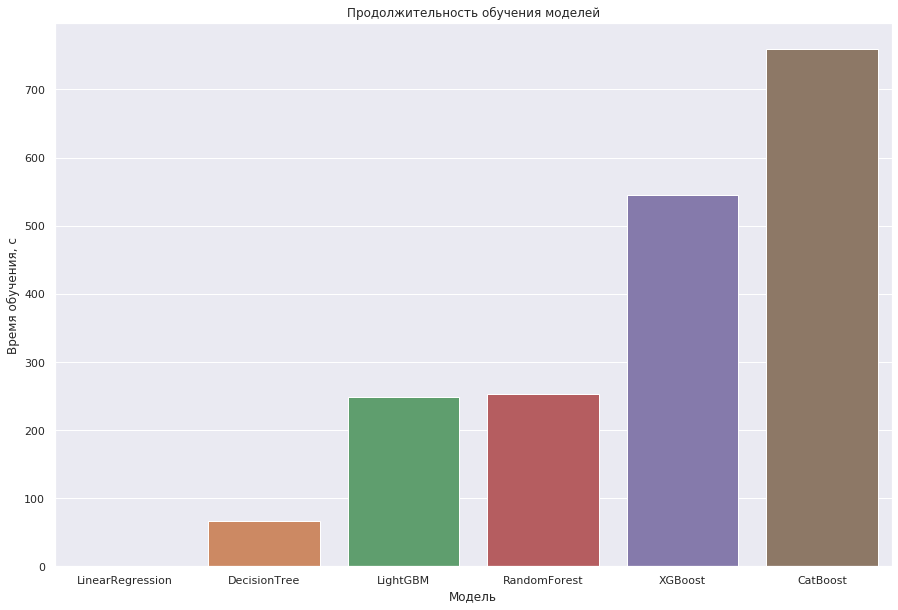

In [237]:
plot_df = plot_df.sort_values(['learning_time'], ascending=True)
ax = sns.barplot(x=plot_df['model'], y=plot_df['learning_time'], data=plot_df)
plt.xlabel("Модель")
plt.ylabel("Время обучения, с")
plt.title("Продолжительность обучения моделей")
plt.show()

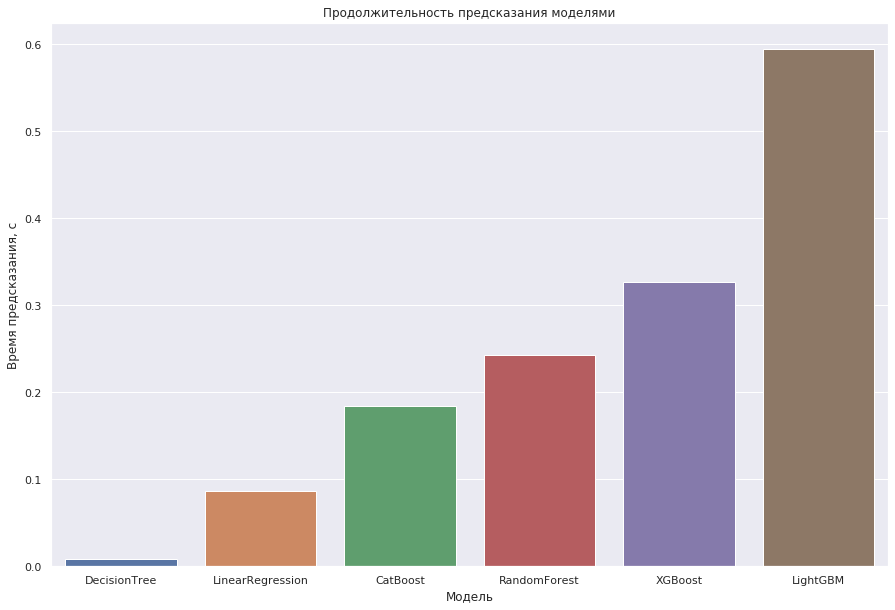

In [238]:
plot_df = plot_df.sort_values(['predict_time'], ascending=True)
ax = sns.barplot(x=plot_df['model'], y=plot_df['predict_time'], data=plot_df)
plt.xlabel("Модель")
plt.ylabel("Время предсказания, с")
plt.title("Продолжительность предсказания моделями")
plt.show()

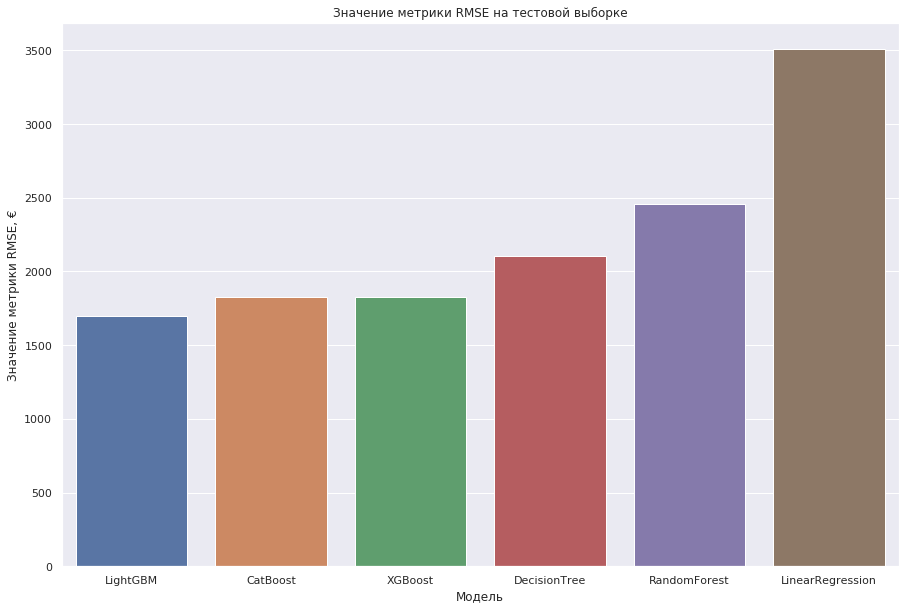

In [239]:
plot_df = plot_df.sort_values(['score'], ascending=True)
ax = sns.barplot(x=plot_df['model'], y=plot_df['score'], data=plot_df)
plt.xlabel("Модель")
plt.ylabel("Значение метрики RMSE, €")
plt.title("Значение метрики RMSE на тестовой выборке")
plt.show()

## Выводы

Видим, что простые модели обучаются быстро, быстро делают предсказание, но их точность очень низкая.  


Если учитывать что время предсказания в 0.6с не является критичным, то лучшим выбором будет модель из библиотеки LightGBM, поскольку у неё лучшее значение метрики RMSE, время обучения в три раза быстрее чем у CatBoost, почти в два раза быстрее чем у XGBoost.  


Если критично время предсказания, то стоит выбрать модель из библиотеки СatBoost: высокая скорость предсказания, значение RMSE больше чем у LightGBM не более чем на 150 евро, но время обучения больше всех.